# Spiking Rates for a model with 5 dense layers of equal neurons

## Initialize data

In [1]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
import tensorflow as tf
import nengo_dl
import copy

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
# obtain images
(train_images, train_labels), (test_images,test_labels) = tf.keras.datasets.cifar10.load_data()

# normalize data by color channel
def normalize(array):
    return (array - np.mean(array)) / np.std(array)

train_images_R = normalize(train_images.transpose()[0].transpose())
train_images_G = normalize(train_images.transpose()[1].transpose())
train_images_B = normalize(train_images.transpose()[2].transpose())
test_images_R = normalize(test_images.transpose()[0].transpose())
test_images_G = normalize(test_images.transpose()[1].transpose())
test_images_B = normalize(test_images.transpose()[2].transpose())

train_images = np.array([train_images_R, train_images_G, train_images_B])
test_images = np.array([test_images_R, test_images_G, test_images_B])

train_images = np.moveaxis(train_images, 0, -1)
test_images = np.moveaxis(test_images, 0, -1)

# verify normalization
print((train_images.shape, train_labels.shape), (test_images.shape, test_labels.shape))
print('test mean:', np.mean(train_images))
print('test stdv:', np.std(train_images))
print('train mean:', np.mean(test_images))
print('train stdv:', np.std(test_images))

((50000, 32, 32, 3), (50000, 1)) ((10000, 32, 32, 3), (10000, 1))
test mean: 5.4830214442821065e-17
test stdv: 1.0000000000000002
train mean: 8.14903700074865e-18
train stdv: 1.0000000000000002


In [3]:
# flatten images and add time dimension
train_images = train_images.reshape((train_images.shape[0], 1, -1))
train_labels = train_labels.reshape((train_labels.shape[0], 1, -1))
test_images = test_images.reshape((test_images.shape[0], 1, -1))
test_labels = test_labels.reshape((test_labels.shape[0], 1, -1))

print((train_images.shape, train_labels.shape), (test_images.shape, test_labels.shape))

((50000, 1, 3072), (50000, 1, 1)) ((10000, 1, 3072), (10000, 1, 1))


## Build network and convert to nengo-dl

In [4]:
inp = tf.keras.Input(shape=(32, 32, 3))

conv0 = tf.keras.layers.Conv2D(filters=32, kernel_size=2, activation=tf.nn.relu)(inp)
pool0 = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(conv0)

conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=2, activation=tf.nn.relu)(pool0)
pool1 = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(conv1)

conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=2, activation=tf.nn.relu)(pool1)
pool2 = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(conv2)

flatten = tf.keras.layers.Flatten()(pool2)

dense0 = tf.keras.layers.Dense(units=300, activation=tf.nn.relu)(flatten)
out = tf.keras.layers.Dense(units=10)(dense0)

model = tf.keras.Model(inputs=inp, outputs=out)

In [5]:
converter = nengo_dl.Converter(model)

## Train the non-spiking network

In [61]:
with nengo_dl.Simulator(converter.net, minibatch_size=200) as sim:
    
    sim.compile(
        optimizer=tf.optimizers.Adam(0.001),
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.sparse_categorical_accuracy]
    )

    sim.fit(
        {converter.inputs[inp]: train_images},
        {converter.outputs[out]: train_labels},
        validation_data=({converter.inputs[inp]: test_images}, {converter.outputs[out]: test_labels}),
        epochs=20
    )

    # save the parameters
    sim.save_params("./equal_cnn_params")

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Epoch 1/20
250/250 [==============================] - 39s 79ms/step - loss: 1.8004 - probe_loss: 1.8004 - probe_sparse_categorical_accuracy: 0.3441 - val_loss: 1.3571 - val_probe_loss: 1.3571 - val_probe_sparse_categorical_accuracy: 0.5067
Epoch 2/20
250/250 [==============================] - 19s 76ms/step - loss: 1.3209 - probe_loss: 1.3209 - probe_sparse_categorical_accuracy: 0.5270 - val_loss: 1.2044 - val_probe_loss: 1.2044 - val_probe_sparse_categorical_accuracy: 0.5704
Epoch 3/20
250/250 [==============================] - 22s 86ms/step - loss: 1.1490 - probe_loss: 1.1490 - probe_sparse_categorical_accuracy: 0.5938 - val_loss: 1.0642 - val_probe_loss: 1.0642 - val_probe_sparse_categorical_accuracy: 0.6231
Epoch 4/20
250/250 [====================

## Run the non-spiking network

In [6]:
probed_layers = [conv0, conv1, conv2, dense0]

probed_layer_to_model_layer_dict = {
    inp.ref(): model.layers[0],
    conv0.ref(): model.layers[1],
    conv1.ref(): model.layers[3],
    conv2.ref(): model.layers[5],
    dense0.ref(): model.layers[8],
    out.ref(): model.layers[-1],
}

In [7]:
def run_network(
    activation,
    params_file="equal_cnn_params",
    n_steps=30,
    scale_firing_rates=1,
    synapse=None,
    n_test=400,
    n_images_for_rates=1,
    n_sample_neurons=100,
):
    # convert the keras model to a nengo network
    nengo_converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: activation},
        scale_firing_rates=scale_firing_rates,
        synapse=synapse,
    )

    # get input/output objects
    nengo_input = nengo_converter.inputs[inp]
    nengo_output = nengo_converter.outputs[out]

    # add a probe to the first convolutional layer to record activity.
    # we'll only record from a subset of neurons, to save memory.
    sample_neurons = np.array([
        np.linspace(0, np.prod(layer.shape[1:]), n_sample_neurons, endpoint=False, dtype=np.int32) for layer in probed_layers
    ])

    # set probes
    with nengo_converter.net:
        probes = np.array([
            nengo.Probe(nengo_converter.layers[probed_layers[l]][sample_neurons[l]]) for l in range(len(probed_layers))
        ])

    probe_to_model_layer_dict = { probes[l]: probed_layer_to_model_layer_dict[probed_layers[l].ref()] for l in range(len(probed_layers)) }

    # repeat inputs for some number of timesteps
    tiled_test_images = np.tile(test_images[:n_test], (1, n_steps, 1))

    # set some options to speed up simulation
    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    # build network, load in trained weights, run inference on test images
    with nengo_dl.Simulator(nengo_converter.net, minibatch_size=200, progress_bar=False) as nengo_sim:
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: tiled_test_images})

    # compute accuracy on test data, using output of network on
    # last timestep
    predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    accuracy = (predictions == test_labels[:n_test, 0, 0]).mean()
    print(f" test accuracy: {100 * accuracy:.2f}%")

    rates_for_images = []
    for image in range(n_images_for_rates):
        if isinstance(scale_firing_rates, dict):
            scaled_data = np.array([
                data[probe][image] * scale_firing_rates[probe_to_model_layer_dict[probe]] for probe in probes
            ])
        else:
            scaled_data = np.array([
                data[probe][image] * scale_firing_rates for probe in probes
            ])
                
        if isinstance(activation, nengo.SpikingRectifiedLinear) or isinstance(activation, nengo.LIF):
            scaled_data /= n_sample_neurons
            layer_rates = np.array([
                np.sum(scaled_data[i], axis=0) / (n_steps * nengo_sim.dt) for i in range(len(scaled_data))
            ])
        else:
            layer_rates = scaled_data

        rates_for_images.append(layer_rates)
       
    avg_layer_rates = np.mean(np.array(rates_for_images), axis=0)

    return (accuracy, avg_layer_rates)

In [8]:
baseline_accuracy, baseline_rates = run_network(activation=nengo.RectifiedLinear(), n_steps=10)

 test accuracy: 73.25%


In [11]:
n_steps=60
synapse=0.005
scale_firing_rates=200
n_images_for_rates=100
n_sample_neurons=100

spiking_accuracy, spiking_rates = run_network(
        activation=nengo.SpikingRectifiedLinear(), 
        n_steps=n_steps, 
        synapse=synapse, 
        scale_firing_rates=scale_firing_rates,
        n_images_for_rates=n_images_for_rates,
        n_sample_neurons=n_sample_neurons,
    )

 test accuracy: 71.25%


C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


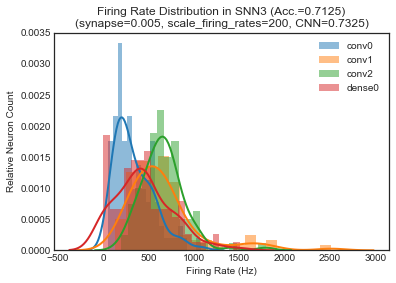

In [18]:
# create plots of layer rates
import seaborn as sns
sns.set_style("white")
for l in range(len(spiking_rates)):
    rate_data = spiking_rates[l]

    plt.xlabel("Firing Rate (Hz)")
    plt.ylabel("Relative Neuron Count")
    plt.title("Firing Rate Distribution in SNN"+str(l)+" (Acc.=" + str(spiking_accuracy) + ")\n(synapse="+str(synapse)+", scale_firing_rates="+str(scale_firing_rates)+", CNN="+str(baseline_accuracy)+")")
    labels = ['conv0', 'conv1', 'conv2', 'dense0']

    kwargs = dict(hist_kws={'alpha':.5}, kde_kws={'linewidth':2})
    
    # for l in rate_data:
    s = sns.distplot(rate_data, bins=20, label=labels[l], norm_hist=False, **kwargs) # color=sns.color_palette()[l]
    s.legend()
    plt.savefig("./images/layer_"+str(l)+"_bar_spiking_rates_"+str(n_images_for_rates)+"im_"+str(synapse)[2:]+"_"+str(scale_firing_rates)+"_neurons="+str(n_sample_neurons), dpi=300)
    # plt.close()

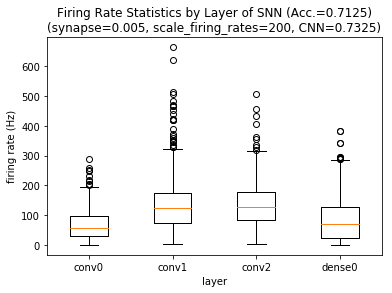

In [29]:
# create plots of layer rates
rate_data = spiking_rates.swapaxes(0, 1)

plt.xlabel("layer")
plt.ylabel("firing rate (Hz)")
plt.title("Firing Rate Statistics by Layer of SNN (Acc.=" + str(spiking_accuracy) + ")\n(synapse="+str(synapse)+", scale_firing_rates="+str(scale_firing_rates)+", CNN="+str(baseline_accuracy)+")")

labels = ['conv0', 'conv1', 'conv2', 'dense0']
plt.boxplot(rate_data, labels=labels, showfliers=True)
plt.savefig("./images/spiking_rates_"+str(n_images_for_rates)+"im_"+str(synapse)[2:]+"_"+str(scale_firing_rates)+"_neurons="+str(n_sample_neurons), dpi=400)

## Scale the firing rates for each layer at a time

In [ ]:
synapse = 0.005
base_scale_firing_rates = 50
special_scale_firing_rates = 200
accuracy_and_rates = []

accuracy_and_rates.append(
    run_network(
        activation=nengo.SpikingRectifiedLinear(),
        n_steps=60,
        synapse=synapse,
        scale_firing_rates=special_scale_firing_rates,
    )
)

accuracy_and_rates.append(
    run_network(
        activation=nengo.SpikingRectifiedLinear(),
        n_steps=60,
        synapse=synapse,
        scale_firing_rates=base_scale_firing_rates,
    )
)

scale_firing_rates = {layer:base_scale_firing_rates for layer in model.layers}

for l in [1, 3, 5, 8]:
    scale_firing_rates[model.layers[l]] = special_scale_firing_rates

    print("Scaled layer: " + model.layers[l]._name)
    accuracy_and_rates.append(
        run_network(
            activation=nengo.SpikingRectifiedLinear(),
            n_steps=60,
            synapse=synapse,
            scale_firing_rates=scale_firing_rates,
        )
    )
    scale_firing_rates[model.layers[l]] = base_scale_firing_rates

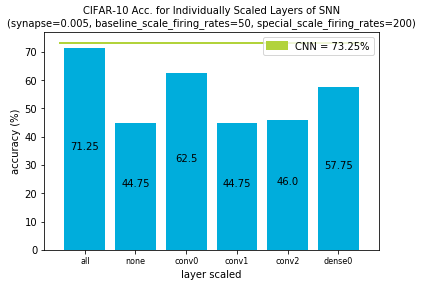

In [25]:
# create graph of accuracy
accuracy_list = np.array([e[0] for e in accuracy_and_rates])

fig, ax = plt.subplots(1,1)
baseline = plt.Rectangle((-0.5,73.25), 6,0, fill=True, color='#B2D33B', linewidth=2, zorder=2)
baseline.set_label('CNN = ' + str(baseline_accuracy * 100) + '%')
ax = ax or plt.gca()
ax.add_patch(baseline)
ax.legend()

def add_labels(y):
    for i in range(len(y)):
        plt.text(i, y[i]*100/2, str(round(y[i]*100,3)), ha='center')

add_labels(accuracy_list)

plt.xlabel("layer scaled")
plt.ylabel("accuracy (%)")
plt.title("CIFAR-10 Acc. for Individually Scaled Layers of SNN\n(synapse=" + str(synapse) + ", baseline_scale_firing_rates=" + str(base_scale_firing_rates) + ", special_scale_firing_rates=" + str(special_scale_firing_rates) + ")", size=10)

labels = ['all', 'none', 'conv0', 'conv1', 'conv2', 'dense0']
plt.bar(labels, accuracy_list*100, color='#00ADDC')
plt.xticks(rotation=0, size=8)
plt.savefig("./images/individually_scaled_layers_" + str(synapse)[2:] + "_" + str(base_scale_firing_rates) + "_" + str(special_scale_firing_rates), dpi=300)

In [ ]:
# scale layers in pairs
synapse = 0.005
base_scale_firing_rates = 50
special_scale_firing_rates = 150
accuracy_list = []

accuracy_list.append(
    run_network(
        activation=nengo.SpikingRectifiedLinear(),
        n_steps=60,
        synapse=synapse,
        scale_firing_rates=base_scale_firing_rates,
    )
)

scale_firing_rates = {layer:base_scale_firing_rates for layer in model.layers}
pairs = [(1,3), (3,5), (5, 8), (8, 9)]

for pair in pairs:

    scale_firing_rates[model.layers[pair[0]]] = special_scale_firing_rates
    scale_firing_rates[model.layers[pair[1]]] = special_scale_firing_rates

    print("Scaled layer: " + model.layers[l]._name)
    accuracy = run_network(
        activation=nengo.SpikingRectifiedLinear(),
        n_steps=60,
        synapse=synapse,
        scale_firing_rates=scale_firing_rates)

    accuracy_list.append(accuracy)

    scale_firing_rates[model.layers[pair[0]]] = base_scale_firing_rates
    scale_firing_rates[model.layers[pair[1]]] = base_scale_firing_rates

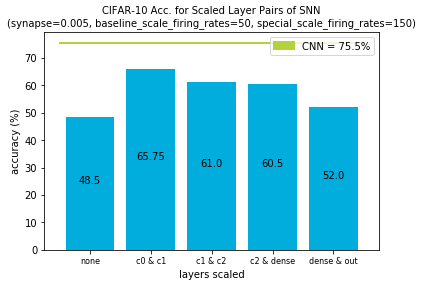

In [167]:
# create graph for scaling in pairs
fig, ax = plt.subplots(1,1)
baseline = plt.Rectangle((-0.5,75.5), 5,0, fill=True, color='#B2D33B', linewidth=2, zorder=2)
baseline.set_label('CNN = ' + str(baseline_accuracy * 100) + '%')
ax = ax or plt.gca()
ax.add_patch(baseline)
ax.legend()

def addlabels(y):
    for i in range(len(y)):
        plt.text(i, y[i]*100/2, str(round(y[i]*100,3)), ha='center')

addlabels(accuracy_list)

accuracy_list = np.array(accuracy_list)
plt.xlabel("layers scaled")
plt.ylabel("accuracy (%)")
plt.title("CIFAR-10 Acc. for Scaled Layer Pairs of SNN\n(synapse=" + str(synapse) + ", baseline_scale_firing_rates=" + str(base_scale_firing_rates) + ", special_scale_firing_rates=" + str(special_scale_firing_rates) + ")", size=10)
# labels = [layer._name for layer in model.layers[2:]]
labels = ['none', 'c0 & c1', 'c1 & c2', 'c2 & dense', 'dense & out']
plt.bar(labels, accuracy_list*100, color='#00ADDC')
plt.xticks(rotation=0, size=8)
plt.savefig("./scaling_early_and_late_images/3_conv/barred_pairs_" + str(synapse)[2:] + "_" + str(base_scale_firing_rates) + "_" + str(special_scale_firing_rates), dpi=300)